In [ ]:
# 必要なライブラリをインストール・インポートしておく
! pip install -U japanmap jupyter pandas xlrd
! pip install matplotlib==3.1.3
! pip install -U xlsxwriter
! pip install japanize-matplotlib
import os, io, glob,time,sys
import json, requests, regex, xlsxwriter, openpyxl
import pandas as pd
import matplotlib.pyplot as plt
from japanmap import picture
from openpyxl import load_workbook

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# mainの処理で呼び出す関数を書いておく

def convert_zipcode(postal_code,row_locator):
  """
  Pandasデータフレーム内のzip列、行番号を入力し、県,市区の列を返す  
  """
  # アクセス前に1秒間のスリープ時間を持たせる(※これより短いと、APIサーバ側からアクセス拒否される)
  time.sleep(1.1)

  # 呼びだすAPI元のURL
  RECEST_URL = "http://zipcloud.ibsnet.co.jp/api/search?zipcode={0}".format(postal_code)
    
  # HTTPヘッダにユーザーエージェント(User Agent)を設定してあげる
  dummy_user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) Gecko/20100101 Firefox/47.0'
  response = requests.get(RECEST_URL,headers={"User-Agent": dummy_user_agent})
    
  json_result = response.text
  json_to_dic_result = json.loads(response.text)

  # 該当する情報の判定
  if json_to_dic_result["message"] == None:
    # resultキーでエラーが起きる場合
    if json_to_dic_result["results"] == None:
      target_data["都道府県"][row_locator] = "該当なし"
      target_data["市区"][row_locator] = "該当なし"
      target_data["市"][row_locator] = "該当なし"
      return
    else: # resultキーに対応するリスト内タプルを取得
      result_dic = json_to_dic_result["results"][0]

  else: # messageキーでエラーが起きる場合 
    print("No Matched Address: ZIP Code Typo?")
    target_data["都道府県"][row_locator] = "該当なし"
    target_data["市区"][row_locator] = "該当なし"
    target_data["市"][row_locator] = "該当なし"
    return
    
  # target_dataに値を返す
  target_data["都道府県"][row_locator] = result_dic["address1"] 
  target_data["市区"][row_locator] = result_dic["address2"]
  target_data["市"][row_locator] = regex.search(".+?(市|区|郡)", target_data["市区"][row_locator]).group()# 重要；orで市or区or郡で分岐する
  return


def append_sum_row_label(df):
  """groubpyされたdataframeを入力とし、その末尾に集計総数をappendして返す"""
  df.loc['合計'] = df.sum()
  return df

def heatmap(agg):
  """県ごとの注文集計をヒートマップ形式で表示し、その画像ファイルをオブジェクトで返す"""
  cmap = plt.get_cmap('Reds')
  norm = plt.Normalize(vmin=agg.min(), vmax=agg.max())
  fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()

  fig, ax = plt.subplots()

  fig.colorbar(plt.cm.ScalarMappable(norm, cmap))
  ax.imshow(picture(agg.apply(fcol)))
  print("集計結果を表示します：")
  #  PCのメモリに画像を保持する
  imgdata = io.BytesIO()
  fig.savefig(imgdata, format='png', dpi=300)
  return imgdata


入力フォルダ内にある、郵便番号を含む注文データファイルを入力してください：〜.xlsx
sample01_3month.xlsx
meero shooting 2021-06-10T0913.xlsx
>> sample01_3month.xlsx
集計結果を表示します：


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).


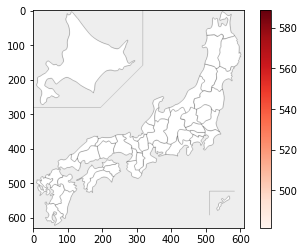

In [ ]:
# 0. 事前準備
# 作業フォルダパスをつなぐ

working_dir = '住所検索集計'
path = f'/content/drive/MyDrive/Colab Notebooks/GithubPF_sandbox/{working_dir}/'
os.chdir(path)

# 各入出力フォルダを生成
data_dir = "data"
input_dir = os.path.join(data_dir, "0_input")
output_dir = os.path.join(data_dir, "10_output")
os.makedirs(input_dir,exist_ok=True)
os.makedirs(output_dir,exist_ok=True)


def main():
  # 1. 読み込み
  print('入力フォルダ内にある、郵便番号を含む注文データファイルを入力してください：〜.xlsx')
  for f in glob.glob(f'{input_dir}/*.xlsx'):
    print(os.path.split(f)[1])
  target_file = input('>> ')
  fpath = os.path.join(input_dir,target_file)
  target_data = pd.read_excel(fpath)

  # 2. 格納データオブジェクトに都道府県・市区列を追加し、必要な列のみ選択
  target_data[["都道府県", "市区", "市","区", "地方区分"]] = ""
  target_data = target_data[["ZIP Code","地方区分","都道府県","市区", "市"]]

  # 3. 外部APIを用いて、郵便番号から都道府県・市区を出力
  for i in range(0,len(target_data)):
    convert_zipcode(target_data["ZIP Code"][i],i)

  # 4. 注文件数を各粒度（県・市）で集計する
  byPref = target_data.groupby("都道府県").count()["ZIP Code"] .sort_values(ascending=False)
  append_sum_row_label(byPref)

  # 市レベルの注文数を集計（今回はインスタンスに愛知県を使用）
  target_pref = "愛知県"
  byCity = target_data.loc[target_data["都道府県"] == target_pref].groupby("市").count()["ZIP Code"].sort_values(ascending=False)
  append_sum_row_label(byCity)

  # 5. 集計結果を各ワークシートにまとめ、出力フォルダにXSLX形式ファイルに格納
  export_to = os.path.join(output_dir,f'report_{target_file}')
  with pd.ExcelWriter(export_to, engine = 'xlsxwriter') as writer:
    byPref.to_excel(writer, sheet_name = '都道府県毎の集計結果')
    byCity.to_excel(writer, sheet_name = f'市毎の集計結果({target_pref})')
    target_data.to_excel(writer, sheet_name = '集計元データ(住所)')

  # 可視化したデータをPCのメモリに保持する
  imgdata = heatmap(byPref)

  #  ワークブックを再度開いて、可視化データを乗せるワークシートを用意
  wb = load_workbook(export_to)
  ws = wb.get_sheet_by_name('都道府県毎の集計結果')

  # 画像データをリサイズし、既存のワークシートに追加
  img = openpyxl.drawing.image.Image(imgdata)
  img.height = 25 * 10  # 10セル行分
  img.width = 72 * 7    # 7セル列分
  ws.add_image(img, 'D1')
  wb.save(export_to)
  wb.close()

  return

main()